<a href="https://colab.research.google.com/github/Hazhar-Rahmani/Business-Analytics2/blob/main/W025_G01_Group_Project_Report_G2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Motivation
The Google Play Store is home to millions of apps, and user ratings significantly impact their visibility and downloads. The purpose of this project was to explore **what factors most influence the ratings an app receives**, using a combination of app features and user review sentiment. We aimed to apply both **Error-Based** and **Similarity-Based** machine learning models to extract meaningful patterns and deliver actionable insights.

In the age of **AI-driven analysis**, understanding these factors is crucial for developers aiming to optimize their app’s performance and visibility. By leveraging AI, we can predict app ratings and identify the most impactful features, guiding developers to focus on the aspects that matter most to users.

**Key Questions:**
- What factors influence the ratings an app receives on the Google Play Store?
- How do **review count**, **sentiment scores**, and **app update frequency** impact app ratings?


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML preprocessing, modeling, and evaluation
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb


## Loading and Reviewing the Dataset

We're starting by loading two datasets from Kaggle about the Google Play Store:

- **googleplaystore.csv**: This file contains general information about each app, like its category, number of installs, size, price, and overall rating.
- **googleplaystore_user_reviews.csv**: This file includes user reviews for various apps along with sentiment labels and polarity scores.

After loading them into pandas DataFrames, we'll take a quick look at the shape of each dataset and how many unique apps are included. This gives us a basic understanding of the data before we move on to cleaning and merging.


In [ ]:
import pandas as pd

# Use your raw URLs from GitHub
apps_url = 'https://raw.githubusercontent.com/Hazhar-Rahmani/Business-Analytics2/8bc8473d4e91f42b55e6ba8bd109072680d9dd81/googleplaystore.csv'
reviews_url = 'https://raw.githubusercontent.com/Hazhar-Rahmani/Business-Analytics2/8bc8473d4e91f42b55e6ba8bd109072680d9dd81/googleplaystore_user_reviews.csv'

# Load the datasets
apps = pd.read_csv(apps_url)
reviews = pd.read_csv(reviews_url)

# Display the first few rows to verify
print(apps.head())
print(reviews.head())


                                                 App        Category  Rating  \
0     Photo Editor & Candy Camera & Grid & ScrapBook  ART_AND_DESIGN     4.1   
1                                Coloring book moana  ART_AND_DESIGN     3.9   
2  U Launcher Lite – FREE Live Cool Themes, Hide ...  ART_AND_DESIGN     4.7   
3                              Sketch - Draw & Paint  ART_AND_DESIGN     4.5   
4              Pixel Draw - Number Art Coloring Book  ART_AND_DESIGN     4.3   

  Reviews  Size     Installs  Type Price Content Rating  \
0     159   19M      10,000+  Free     0       Everyone   
1     967   14M     500,000+  Free     0       Everyone   
2   87510  8.7M   5,000,000+  Free     0       Everyone   
3  215644   25M  50,000,000+  Free     0           Teen   
4     967  2.8M     100,000+  Free     0       Everyone   

                      Genres      Last Updated         Current Ver  \
0               Art & Design   January 7, 2018               1.0.0   
1  Art & Design;Pretend 

In [ ]:
print(apps.shape, len(apps['App'].unique()))
print(reviews.shape, len(reviews['App'].unique()))

(10841, 13) 9660
(64295, 5) 1074


### Sorting the App Dataset by Name

To better understand the structure of the data and prepare for future steps like merging and de-duplication, we first sort the app dataset by the `App` column.

This helps us:
- Easily identify duplicate or similarly named apps
- Ensure consistency when merging with the user reviews dataset (which also uses `App` as a key)
- Visually scan the dataset to spot any unusual entries or formatting issues

This is a small but important step in preparing the data for cleaning and analysis.


In [ ]:
apps.sort_values(by='App', ascending=True)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
8884,"""i DT"" Fútbol. Todos Somos Técnicos.",SPORTS,NaN,27,3.6M,500+,Free,0,Everyone,Sports,"October 7, 2017",0.22,4.1 and up
8532,+Download 4 Instagram Twitter,SOCIAL,4.5,40467,22M,"1,000,000+",Free,0,Everyone,Social,"August 2, 2018",5.03,4.1 and up
324,- Free Comics - Comic Apps,COMICS,3.5,115,9.1M,"10,000+",Free,0,Mature 17+,Comics,"July 13, 2018",5.0.12,5.0 and up
4541,.R,TOOLS,4.5,259,203k,"10,000+",Free,0,Everyone,Tools,"September 16, 2014",1.1.06,1.5 and up
4636,/u/app,COMMUNICATION,4.7,573,53M,"10,000+",Free,0,Mature 17+,Communication,"July 3, 2018",4.2.4,4.1 and up
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6334,"뽕티비 - 개인방송, 인터넷방송, BJ방송",VIDEO_PLAYERS,NaN,414,59M,"100,000+",Free,0,Mature 17+,Video Players & Editors,"July 18, 2018",4.0.7,4.0.3 and up
4362,💎 I'm rich,LIFESTYLE,3.8,718,26M,"10,000+",Paid,$399.99,Everyone,Lifestyle,"March 11, 2018",1.0.0,4.4 and up
2575,"💘 WhatsLov: Smileys of love, stickers and GIF",SOCIAL,4.6,22098,18M,"1,000,000+",Free,0,Everyone,Social,"July 24, 2018",4.2.4,4.0.3 and up
7559,📏 Smart Ruler ↔️ cm/inch measuring for homework!,TOOLS,4.0,19,3.2M,"10,000+",Free,0,Everyone,Tools,"October 21, 2017",1.0,4.2 and up


### Cleaning the App Dataset

We removed rows with missing or duplicate values to keep the dataset clean and consistent before analysis.


In [ ]:
# Dropping null values and duplicates

apps.dropna(inplace=True)
apps.drop_duplicates(inplace=True)
apps.reset_index(drop=True, inplace=True)

In [ ]:
apps.sort_values(by='App', ascending=True)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
7088,+Download 4 Instagram Twitter,SOCIAL,4.5,40467,22M,"1,000,000+",Free,0,Everyone,Social,"August 2, 2018",5.03,4.1 and up
278,- Free Comics - Comic Apps,COMICS,3.5,115,9.1M,"10,000+",Free,0,Mature 17+,Comics,"July 13, 2018",5.0.12,5.0 and up
3902,.R,TOOLS,4.5,259,203k,"10,000+",Free,0,Everyone,Tools,"September 16, 2014",1.1.06,1.5 and up
3988,/u/app,COMMUNICATION,4.7,573,53M,"10,000+",Free,0,Mature 17+,Communication,"July 3, 2018",4.2.4,4.1 and up
5103,058.ba,NEWS_AND_MAGAZINES,4.4,27,14M,100+,Free,0,Everyone,News & Magazines,"July 6, 2018",1.0,4.2 and up
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5488,감성학원 BL 첫사랑,COMICS,4.4,190,34M,"10,000+",Free,0,Everyone,Comics,"November 17, 2017",3.2.1,3.0 and up
3742,💎 I'm rich,LIFESTYLE,3.8,718,26M,"10,000+",Paid,$399.99,Everyone,Lifestyle,"March 11, 2018",1.0.0,4.4 and up
2143,"💘 WhatsLov: Smileys of love, stickers and GIF",SOCIAL,4.6,22098,18M,"1,000,000+",Free,0,Everyone,Social,"July 24, 2018",4.2.4,4.0.3 and up
6283,📏 Smart Ruler ↔️ cm/inch measuring for homework!,TOOLS,4.0,19,3.2M,"10,000+",Free,0,Everyone,Tools,"October 21, 2017",1.0,4.2 and up


### Cleaning and Transforming Key Columns

To prepare the data for analysis, we fixed a few important columns:

- Converted the **Size** column from values like "19M" or "512k" to numbers in kilobytes.
- Cleaned **Installs**, **Price**, and **Reviews** columns by removing symbols and converting them to numbers.
- Changed the **Last Updated** column to a date format and calculated how many days ago each app was last updated.
- Dropped a few columns we didn’t need, like `Genres`.

These steps helped us turn messy string data into clean, usable numbers for analysis.


In [ ]:
# Fixing the 'Size' column
# Converting the 'Size' column to numeric values in KB

def size_to_kbytes(size):
    if isinstance(size, str):
        if 'k' in size:
            return float(size.replace('k', ''))
        elif 'M' in size:
            return float(size.replace('M', '')) * 1024
        elif 'Varies with device' in size:
            return np.nan
    return size

apps['Size'] = apps['Size'].apply(size_to_kbytes)

# filling null values in the 'Size' column with the median size of the respective category

apps['Size'] = apps.groupby('Category')['Size'].transform(lambda x: x.fillna(x.median()))

In [ ]:
# removing unnecessary characters from 'Installs', 'Price', and 'Reviews' columns
# and converting them to appropriate data types

items_to_remove=['+',',','$']
cols_to_clean=['Installs','Price']

for col in cols_to_clean:
    for item in items_to_remove:
        apps[col]=apps[col].str.replace(item,'')

apps['Reviews'] = apps['Reviews'].astype('int')
apps['Installs']=apps['Installs'].astype('int')
apps['Price']=apps['Price'].astype('float')

In [ ]:
# converting the 'last updated' column to datetime format

apps['Last Updated'] = pd.to_datetime(apps['Last Updated'], format='%B %d, %Y', errors='coerce')
apps['Last Day Since Update'] = (apps['Last Updated'].max() - apps['Last Updated']).dt.days

apps.drop('Last Updated', axis=1, inplace=True)

In [ ]:
# apps = apps[~(apps['Reviews'] > 1e6)]
# apps = apps[~(apps['Installs'] > 1e6)]
apps.drop('Genres', axis=1, inplace=True)

Categorical=['Android Ver', 'Category', 'Content Rating', 'Installs', 'Type', "Current Ver"]

le = LabelEncoder()
for col in Categorical:
    print(col, apps[col].unique())
    apps[col] = le.fit_transform(apps[col])

Android Ver ['4.0.3 and up' '4.2 and up' '4.4 and up' '2.3 and up' '3.0 and up'
 '4.1 and up' '4.0 and up' '2.3.3 and up' 'Varies with device'
 '2.2 and up' '5.0 and up' '6.0 and up' '1.6 and up' '1.5 and up'
 '2.1 and up' '7.0 and up' '4.3 and up' '4.0.3 - 7.1.1' '2.0 and up'
 '3.2 and up' '4.4W and up' '5.1 and up' '7.1 and up' '7.0 - 7.1.1'
 '8.0 and up' '5.0 - 8.0' '3.1 and up' '2.0.1 and up' '4.1 - 7.1.1'
 '5.0 - 6.0' '1.0 and up']
Category ['ART_AND_DESIGN' 'AUTO_AND_VEHICLES' 'BEAUTY' 'BOOKS_AND_REFERENCE'
 'BUSINESS' 'COMICS' 'COMMUNICATION' 'DATING' 'EDUCATION' 'ENTERTAINMENT'
 'EVENTS' 'FINANCE' 'FOOD_AND_DRINK' 'HEALTH_AND_FITNESS' 'HOUSE_AND_HOME'
 'LIBRARIES_AND_DEMO' 'LIFESTYLE' 'GAME' 'FAMILY' 'MEDICAL' 'SOCIAL'
 'SHOPPING' 'PHOTOGRAPHY' 'SPORTS' 'TRAVEL_AND_LOCAL' 'TOOLS'
 'PERSONALIZATION' 'PRODUCTIVITY' 'PARENTING' 'WEATHER' 'VIDEO_PLAYERS'
 'NEWS_AND_MAGAZINES' 'MAPS_AND_NAVIGATION']
Content Rating ['Everyone' 'Teen' 'Everyone 10+' 'Mature 17+' 'Adults only 18+' 'Unr

###  Exploring the Data with Visualizations

To better understand patterns in the dataset, we used several visualizations:

- **App Ratings by Category**: A boxplot shows the spread of app ratings in each category. Some categories consistently have higher-rated apps.
- **Reviews vs. Ratings**: A scatter plot reveals whether having more reviews impacts an app's rating. Most highly rated apps have many reviews.
- **Distribution of App Types**: Shows how many apps are free vs. paid — the majority are free.
- **Number of Installs**: A count plot to show how install numbers are distributed — most apps fall into a few common install brackets.

We also added two more helpful charts:

- **App Count by Category**: Displays which categories are the most populated in the Play Store. This shows market competition.
- **Distribution of App Ratings**: A histogram that reveals most apps have ratings between 4.0 and 4.7. Lower-rated apps are less common.

These visual insights help us recognize trends and prepare for feature selection and modeling.


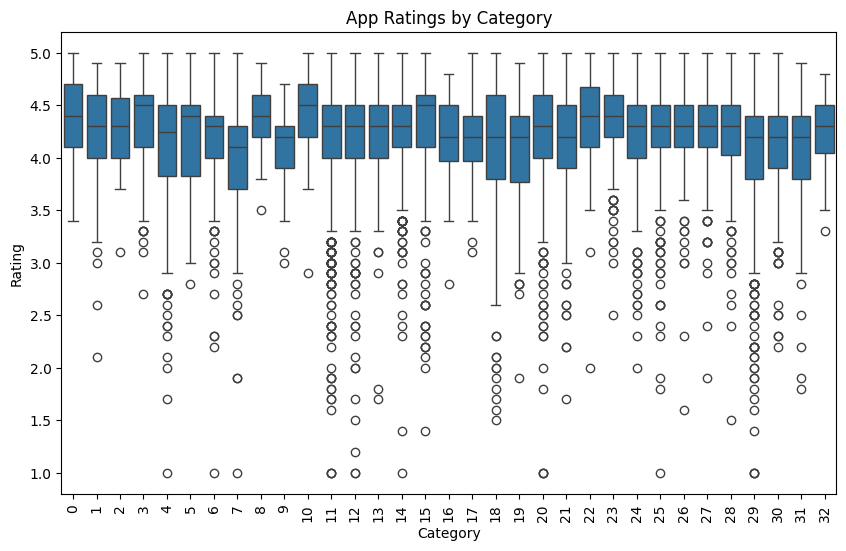

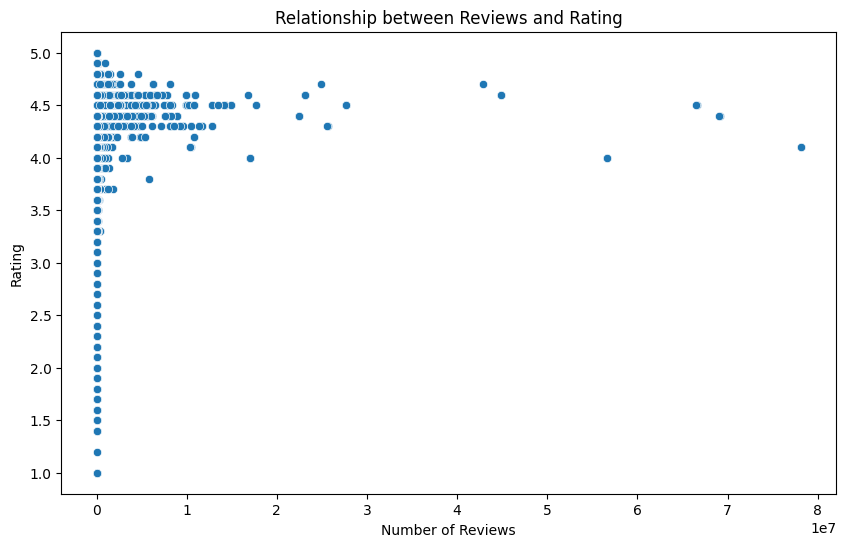

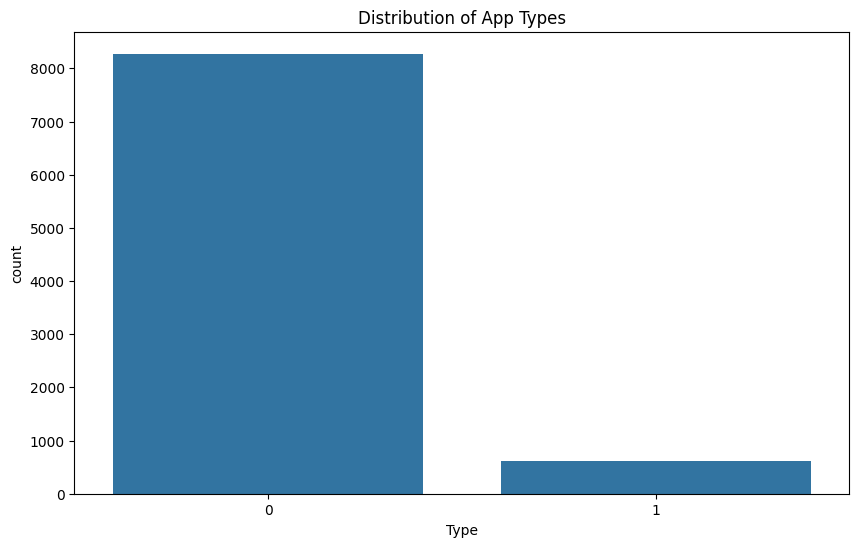

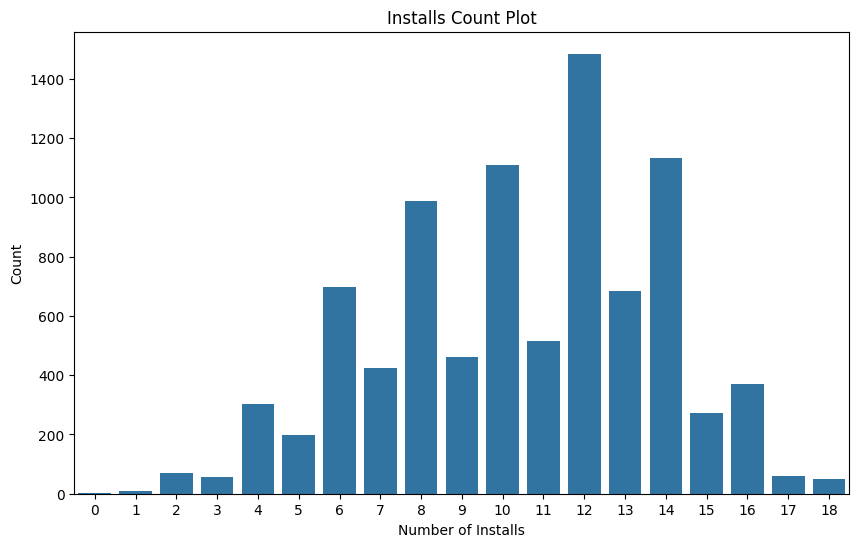

In [ ]:
# Plotting different features
plt.figure(figsize=(10, 6))
sns.boxplot(x='Category', y='Rating', data=apps)
plt.title('App Ratings by Category')
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Reviews', y='Rating', data=apps)
plt.title('Relationship between Reviews and Rating')
plt.xlabel('Number of Reviews')
plt.ylabel('Rating')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='Type', data=apps)
plt.title('Distribution of App Types')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='Installs', data=apps)
plt.title('Installs Count Plot')
plt.xlabel('Number of Installs')
plt.ylabel('Count')
plt.show()


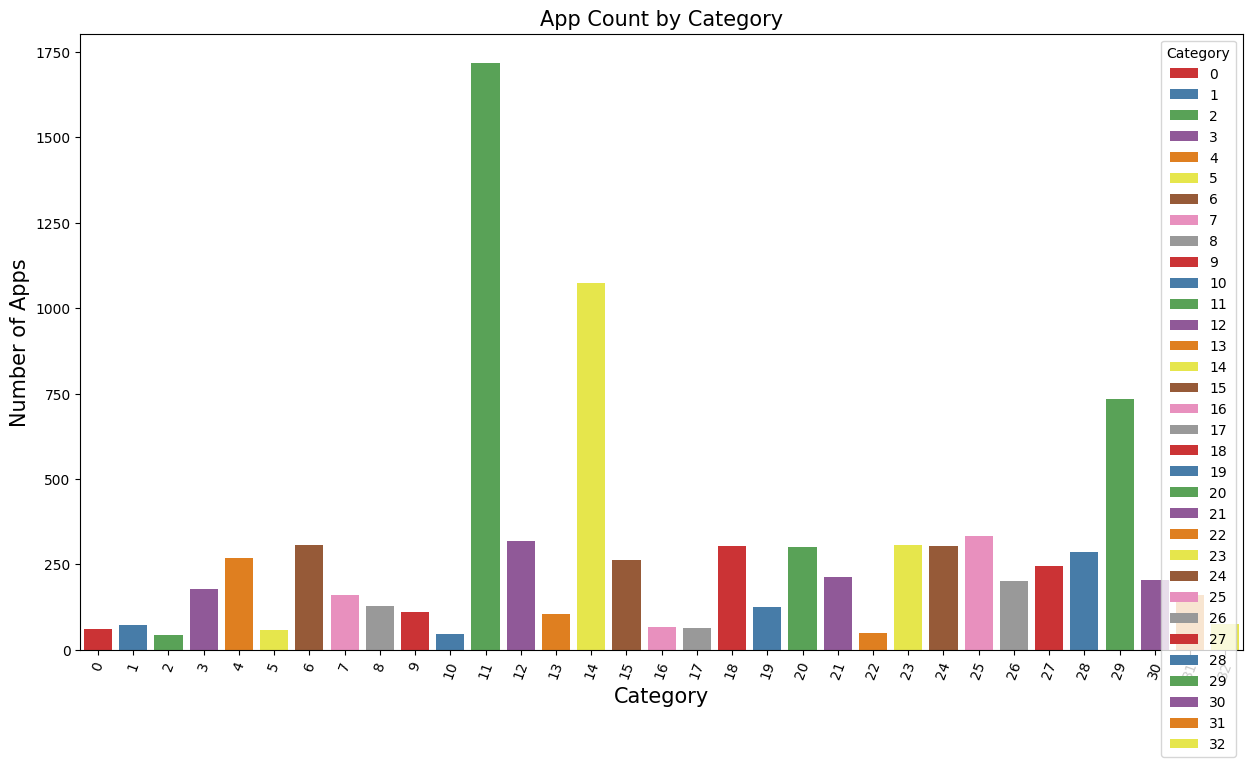

In [ ]:
plt.rcParams['figure.figsize'] = (15, 8)
sns.countplot(x='Category',data=apps,hue="Category" ,palette='Set1')
plt.xlabel('Category', fontsize=15)
plt.ylabel('Number of Apps', fontsize=15)
plt.title("App Count by Category", fontsize=15)
plt.xticks(rotation=70)
plt.show()

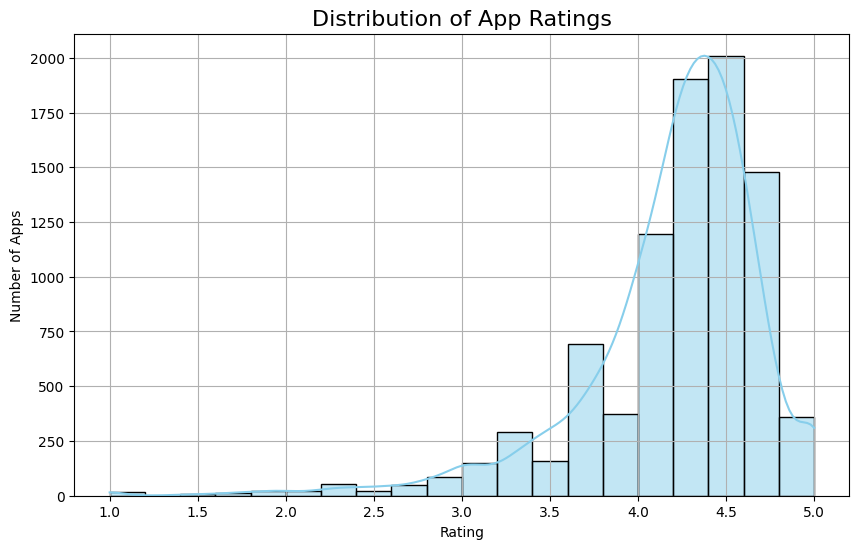

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(apps['Rating'], bins=20, kde=True, color='skyblue')

plt.title('Distribution of App Ratings', fontsize=16)
plt.xlabel('Rating')
plt.ylabel('Number of Apps')
plt.grid(True)
plt.show()

## Anomaly Detection Summary

We used the IQR method to detect outliers in key numerical columns like Rating, Reviews, Size, and Installs.

- Most anomalies were found in:  
  - Reviews (1,555)  
  - Content Rating (1,797)  
  - Android Version (1,195)  

This helped us identify and prepare the data for reliable modeling and analysis.


In [ ]:
numerical_features = apps.select_dtypes(include=np.number).columns

# Initializing a dictionary to store anomaly counts for each feature
anomaly_counts = {}

for feature in numerical_features:
  # Calculate the IQR (Interquartile Range)
  Q1 = apps[feature].quantile(0.25)
  Q3 = apps[feature].quantile(0.75)
  IQR = Q3 - Q1

  # Defining the lower and upper bounds for anomaly detection
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  # Counting anomalies for the current feature
  anomaly_count = len(apps[(apps[feature] < lower_bound) | (apps[feature] > upper_bound)])
  anomaly_counts[feature] = anomaly_count

# Printing the anomaly counts for each numerical feature
for feature, count in anomaly_counts.items():
  print(f"Anomaly count for {feature}: {count}")


Anomaly count for Category: 0
Anomaly count for Rating: 494
Anomaly count for Reviews: 1555
Anomaly count for Size: 582
Anomaly count for Installs: 3
Anomaly count for Type: 611
Anomaly count for Price: 611
Anomaly count for Content Rating: 1797
Anomaly count for Current Ver: 0
Anomaly count for Android Ver: 1195
Anomaly count for Last Day Since Update: 930


In [ ]:
# # Removing anomalies based on IQR for specified features
# features_to_check = ['Reviews', 'Installs', 'Price', 'Size', 'Rating']  # Add other features as needed

# for feature in features_to_check:
#     Q1 = apps[feature].quantile(0.25)
#     Q3 = apps[feature].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 3 * IQR
#     upper_bound = Q3 + 3 * IQR
#     apps = apps[~((apps[feature] < lower_bound) | (apps[feature] > upper_bound))]

# # Resetting the index after removing anomalies
# apps.reset_index(drop=True, inplace=True)


In [ ]:
apps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8886 entries, 0 to 8885
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   App                    8886 non-null   object 
 1   Category               8886 non-null   int64  
 2   Rating                 8886 non-null   float64
 3   Reviews                8886 non-null   int64  
 4   Size                   8886 non-null   float64
 5   Installs               8886 non-null   int64  
 6   Type                   8886 non-null   int64  
 7   Price                  8886 non-null   float64
 8   Content Rating         8886 non-null   int64  
 9   Current Ver            8886 non-null   int64  
 10  Android Ver            8886 non-null   int64  
 11  Last Day Since Update  8886 non-null   int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 833.2+ KB


## Looking at the User Reviews

We loaded the `googleplaystore_user_reviews.csv` file to get a sense of what's inside. It includes thousands of user reviews, and we found that around 1,074 apps have at least one review. Some columns have missing values, but overall it gives us a good look at how users feel about different apps.


In [ ]:
reviews

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000
...,...,...,...,...,...
64290,Houzz Interior Design Ideas,NaN,NaN,NaN,NaN
64291,Houzz Interior Design Ideas,NaN,NaN,NaN,NaN
64292,Houzz Interior Design Ideas,NaN,NaN,NaN,NaN
64293,Houzz Interior Design Ideas,NaN,NaN,NaN,NaN


In [ ]:
len(reviews['App'].unique())

1074

In [ ]:
# Dropping null values and duplicates

# reviews.dropna(inplace=True)
# reviews.drop_duplicates(inplace=True)
# reviews.reset_index(drop=True, inplace=True)

## Visualizing Sentiment

We created a scatter plot to show the relationship between sentiment polarity and subjectivity in the reviews. Each point is color-coded based on whether the review was positive, neutral, or negative. It helps us quickly spot how strong or emotional the reviews are.


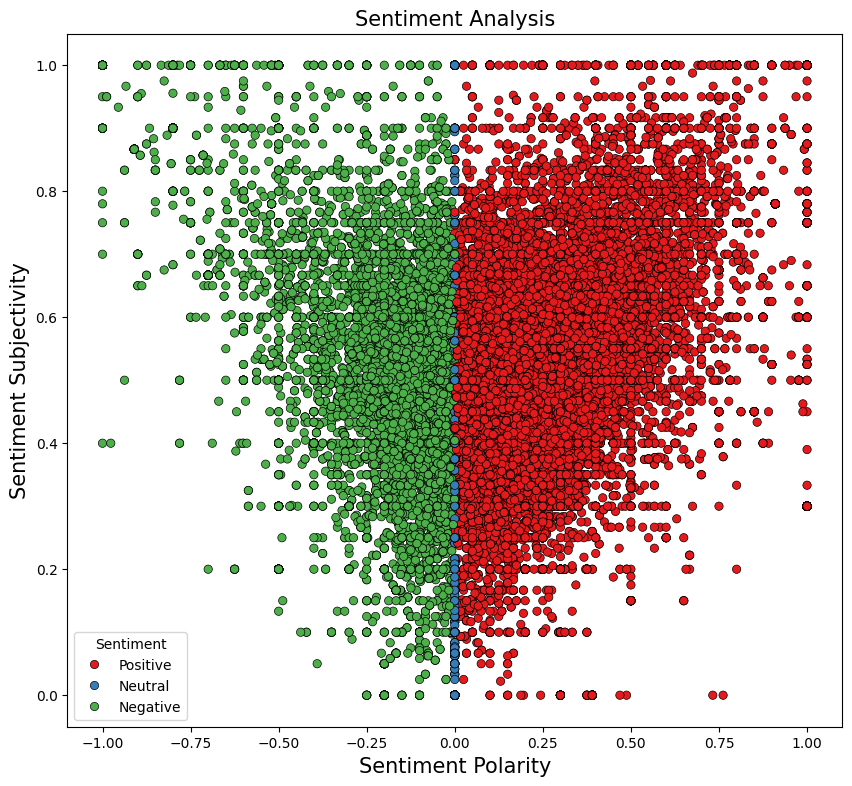

In [ ]:
# Plotting the distribution of reviews

plt.figure(figsize=(10,9))
j = sns.scatterplot(
    data=reviews,
    x=reviews['Sentiment_Polarity'],
    y=reviews['Sentiment_Subjectivity'],
    hue=reviews['Sentiment'],
    edgecolor='black',
    palette="Set1")

plt.xlabel('Sentiment Polarity', fontsize=15)
plt.ylabel('Sentiment Subjectivity', fontsize=15)
plt.title("Sentiment Analysis", fontsize=15)
plt.show()

### Sentiment Feature Engineering (googleplaystore_user_reviews)

We created a function to generate advanced sentiment features for each app. This includes:

- Aggregating sentiment polarity and subjectivity using multiple statistics (mean, std, min, max, median)
- Calculating the ratio of sentiment types (Positive, Negative, Neutral)
- Counting the number of reviews per app
- Handling missing values by filling NaNs with zero

The final `reviews_features_df` gives a clean, app-level sentiment summary ready for analysis or merging with the main dataset.


In [ ]:
def generate_app_sentiment_features(df):
    # Initialize aggregation functions
    agg_funcs = {
        'Sentiment_Polarity': ['mean', 'std', 'min', 'max', 'median'],
        'Sentiment_Subjectivity': ['mean', 'std', 'min', 'max', 'median'],
        'Sentiment': lambda x: x.value_counts(normalize=True).to_dict(),
        'App': 'count'
    }

    # Aggregate the data
    agg_df = df.groupby('App').agg(agg_funcs)

    # Flatten the multi-level columns
    agg_df.columns = ['_'.join(col).strip() if type(col) is tuple else col for col in agg_df.columns]

    # Create sentiment distribution features
    sentiment_dist = agg_df['Sentiment_<lambda>'].apply(pd.Series).fillna(0)
    sentiment_dist.columns = ['Sentiment_'+col+'_Ratio' for col in sentiment_dist.columns]

    # Combine with aggregated data
    agg_df = pd.concat([agg_df.drop(columns='Sentiment_<lambda>'), sentiment_dist], axis=1)

    # Rename the review count feature
    agg_df.rename(columns={'App_count': 'Review_Count'}, inplace=True)

    # Fill NaN values (from apps with all NaNs) with zeros
    agg_df.fillna(0, inplace=True)

    return agg_df.reset_index()

In [ ]:
reviews_features_df = generate_app_sentiment_features(reviews)

In [ ]:
reviews_features_df.sort_values(by='App', ascending=True)

,App,Sentiment_Polarity_mean,Sentiment_Polarity_std,Sentiment_Polarity_min,Sentiment_Polarity_max,Sentiment_Polarity_median,Sentiment_Subjectivity_mean,Sentiment_Subjectivity_std,Sentiment_Subjectivity_min,Sentiment_Subjectivity_max,Sentiment_Subjectivity_median,Review_Count,Sentiment_Positive_Ratio,Sentiment_Neutral_Ratio,Sentiment_Negative_Ratio
0,10 Best Foods for You,0.470733,0.362144,-0.800000,1.000000,0.500000,0.495455,0.294523,0.0,1.0,0.533333,200,0.835052,0.113402,0.051546
1,104 找工作 - 找工作 找打工 找兼職 履歷健檢 履歷診療室,0.392405,0.286072,-0.112500,0.910000,0.433333,0.545516,0.346815,0.0,1.0,0.650000,40,0.775000,0.200000,0.025000
2,11st,0.181294,0.384655,-1.000000,1.000000,0.151515,0.443957,0.318651,0.0,1.0,0.456439,40,0.575000,0.250000,0.175000
3,1800 Contacts - Lens Store,0.318145,0.249727,-0.300000,0.838542,0.340063,0.591098,0.280068,0.0,1.0,0.638636,80,0.800000,0.125000,0.075000
4,1LINE – One Line with One Touch,0.196290,0.409565,-0.825000,1.000000,0.212500,0.557315,0.272385,0.0,1.0,0.600000,40,0.710526,0.078947,0.210526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1069,Hotspot Shield Free VPN Proxy & Wi-Fi Security,0.251765,0.409933,-0.700000,1.000000,0.050000,0.393284,0.371610,0.0,1.0,0.487500,40,0.500000,0.411765,0.088235
1070,Hotstar,0.038178,0.328331,-0.555556,1.000000,0.000000,0.493964,0.229825,0.0,1.0,0.500000,40,0.437500,0.125000,0.437500
1071,Hotwire Hotel & Car Rental App,0.187029,0.378612,-0.875000,0.800000,0.000000,0.459717,0.299023,0.0,0.9,0.566667,40,0.484848,0.333333,0.181818
1072,Housing-Real Estate & Property,-0.021427,0.386664,-0.528571,0.800000,0.000000,0.378532,0.255479,0.0,1.0,0.400000,40,0.380952,0.142857,0.476190


### Merging Cleaned App Data with Sentiment Features
We merged the main `apps` dataset with the sentiment features extracted from `googleplaystore_user_reviews` using the `App` column. This combined dataset provides a comprehensive view of each app, including sentiment statistics and app metadata, and contains 1340 rows and 26 columns with no missing values.


In [ ]:
len(apps['App'].unique())

8190

In [ ]:
merged=pd.merge(apps, reviews_features_df, on='App', how='inner')
merged

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Current Ver,...,Sentiment_Polarity_median,Sentiment_Subjectivity_mean,Sentiment_Subjectivity_std,Sentiment_Subjectivity_min,Sentiment_Subjectivity_max,Sentiment_Subjectivity_median,Review_Count,Sentiment_Positive_Ratio,Sentiment_Neutral_Ratio,Sentiment_Negative_Ratio
0,Coloring book moana,0,3.9,967,14336.0,11,0,0.0,1,952,...,0.500000,0.641540,0.318853,0.000000,1.00,0.600000,58,0.590909,0.090909,0.318182
1,Garden Coloring Book,0,4.4,13791,33792.0,12,0,0.0,1,1365,...,0.300000,0.523447,0.294303,0.000000,1.00,0.598413,100,0.711111,0.177778,0.111111
2,3D Color Pixel by Number - Sandbox Art Coloring,0,4.4,1518,37888.0,10,0,0.0,1,418,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,40,0.000000,0.000000,0.000000
3,FlipaClip - Cartoon animation,0,4.3,194216,39936.0,13,0,0.0,1,1143,...,0.392857,0.679226,0.066047,0.582143,0.73,0.702381,40,1.000000,0.000000,0.000000
4,Boys Photo Editor - Six Pack & Men's Suit,0,4.1,654,12288.0,10,0,0.0,1,250,...,0.341667,0.479298,0.349040,0.000000,1.00,0.600000,40,0.605263,0.263158,0.131579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1335,Garena Free Fire,14,4.5,5534114,54272.0,16,0,0.0,4,444,...,0.075000,0.494133,0.164144,0.000000,1.00,0.476000,240,0.612613,0.022523,0.364865
1336,Fun Kid Racing - Motocross,11,4.1,59768,22528.0,14,0,0.0,1,1670,...,0.150000,0.513577,0.270932,0.000000,1.00,0.512500,40,0.700000,0.100000,0.200000
1337,FarmersOnly Dating,7,3.0,1145,1433.6,10,0,0.0,3,1113,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,40,0.000000,0.000000,0.000000
1338,Firefox Focus: The privacy browser,6,4.4,36981,4096.0,12,0,0.0,1,2083,...,0.218182,0.553828,0.198251,0.000000,1.00,0.566667,80,0.843750,0.093750,0.062500


In [ ]:
merged.columns

Index(['App', 'Category', 'Rating', 'Reviews', 'Size', 'Installs', 'Type',
       'Price', 'Content Rating', 'Current Ver', 'Android Ver',
       'Last Day Since Update', 'Sentiment_Polarity_mean',
       'Sentiment_Polarity_std', 'Sentiment_Polarity_min',
       'Sentiment_Polarity_max', 'Sentiment_Polarity_median',
       'Sentiment_Subjectivity_mean', 'Sentiment_Subjectivity_std',
       'Sentiment_Subjectivity_min', 'Sentiment_Subjectivity_max',
       'Sentiment_Subjectivity_median', 'Review_Count',
       'Sentiment_Positive_Ratio', 'Sentiment_Neutral_Ratio',
       'Sentiment_Negative_Ratio'],
      dtype='object')

In [ ]:
merged.isna().sum()

,0
App,0
Category,0
Rating,0
Reviews,0
Size,0
Installs,0
Type,0
Price,0
Content Rating,0
Current Ver,0


### Merging Data & Exploring Relationships with Ratings  
Merged the app data with aggregated review sentiment features on the `App` column.  
Then, visualized how key features like `Sentiment_Polarity_mean`, `Sentiment_Subjectivity_mean`, and `Review_Count` relate to app `Rating` using scatter plots.


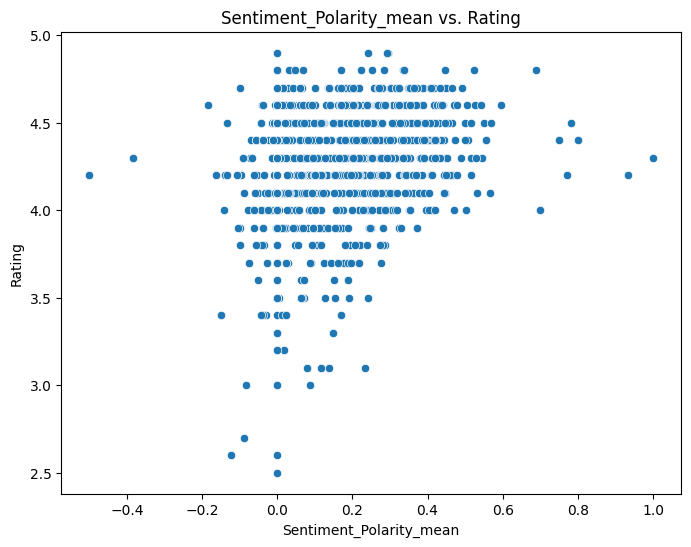

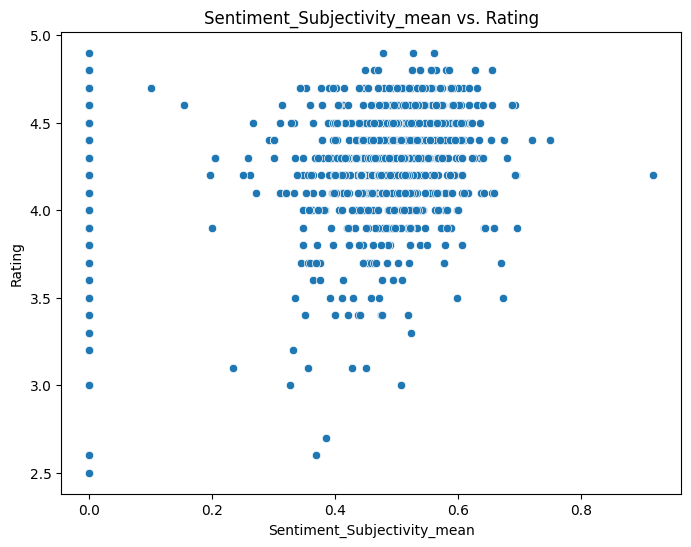

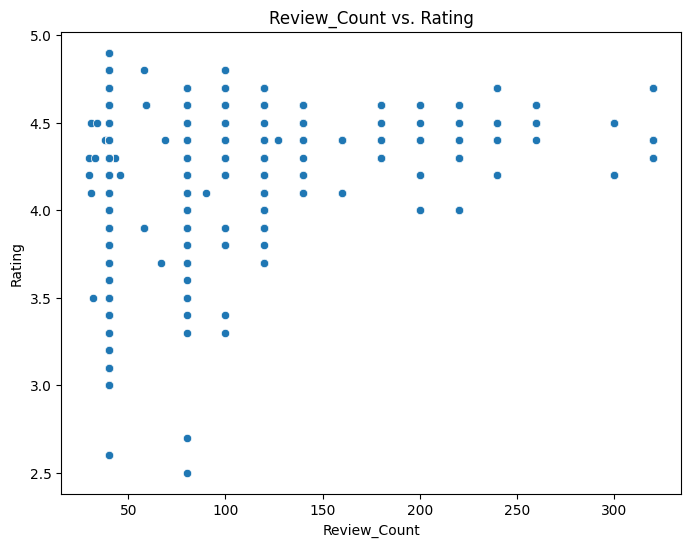

In [ ]:
# Creating figures that plot all numerical variables against the rating
for feature in ["Sentiment_Polarity_mean", "Sentiment_Subjectivity_mean", "Review_Count"]:
  plt.figure(figsize=(8, 6))
  sns.scatterplot(x=feature, y='Rating', data=merged)
  plt.title(f'{feature} vs. Rating')
  plt.xlabel(feature)
  plt.ylabel('Rating')
  plt.show()

### Dataset Overview & Feature Correlation

- Checked structure and completeness of the merged dataset (1,340 rows, 26 columns, no missing values).
- Visualized feature relationships using a correlation heatmap.
- This helps identify strong linear connections (e.g., between polarity metrics or review count & subjectivity), which can inform feature selection for future modeling.


In [ ]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   App                            1340 non-null   object 
 1   Category                       1340 non-null   int64  
 2   Rating                         1340 non-null   float64
 3   Reviews                        1340 non-null   int64  
 4   Size                           1340 non-null   float64
 5   Installs                       1340 non-null   int64  
 6   Type                           1340 non-null   int64  
 7   Price                          1340 non-null   float64
 8   Content Rating                 1340 non-null   int64  
 9   Current Ver                    1340 non-null   int64  
 10  Android Ver                    1340 non-null   int64  
 11  Last Day Since Update          1340 non-null   int64  
 12  Sentiment_Polarity_mean        1340 non-null   f

In [ ]:
target=["Rating"]
features=merged.columns.drop(['App', 'Rating'])

X=merged[features]
y=merged[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


In [ ]:
len(features)

24

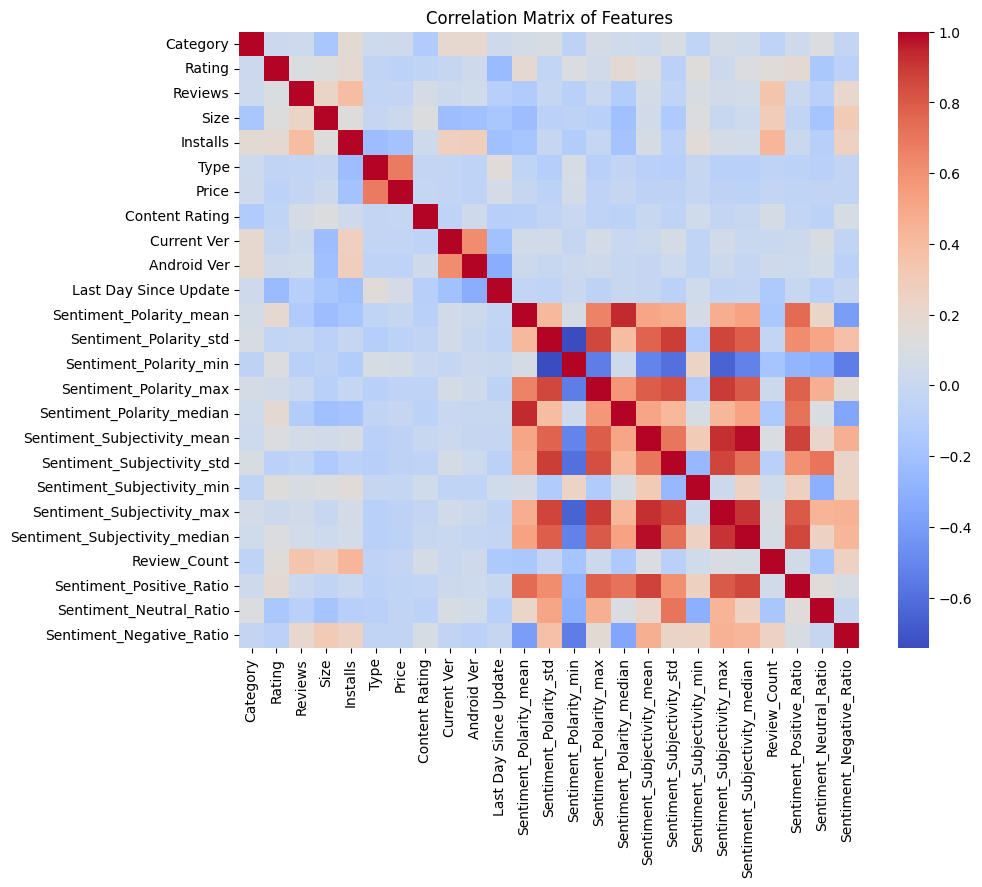

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(merged[merged.columns.drop(['App'])].corr(), annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()

###  Training an ERROR-BASED Learning Algorithm, Random Forest

We implemented a **Random Forest Regressor** to predict app ratings based on various app and sentiment features.

**Model Performance:**
- **Mean Squared Error (MSE):** 0.0529  
- **Mean Absolute Error (MAE):** 0.1433  
- **R² Score:** 0.4333

**Feature Importance Highlights:**
- `Reviews`
- `Last Day Since Update`
- `Current Ver`
- `Size`
- `Sentiment_Positive_Ratio`

**Visual Insights:**
- A **bar chart** showing the most influential features.
- **Scatter plot** of prediction errors with a red baseline.
- **Histogram** of error distribution showing most predictions are close.
- **Actual vs. Predicted** scatter plot with a red diagonal to assess accuracy.

This section demonstrated the model's capability to capture patterns in the dataset, although there's room for improvement.


In [ ]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Mean Squared Error: 0.0529
Mean Absolute Error: 0.1433
R² Score: 0.4333


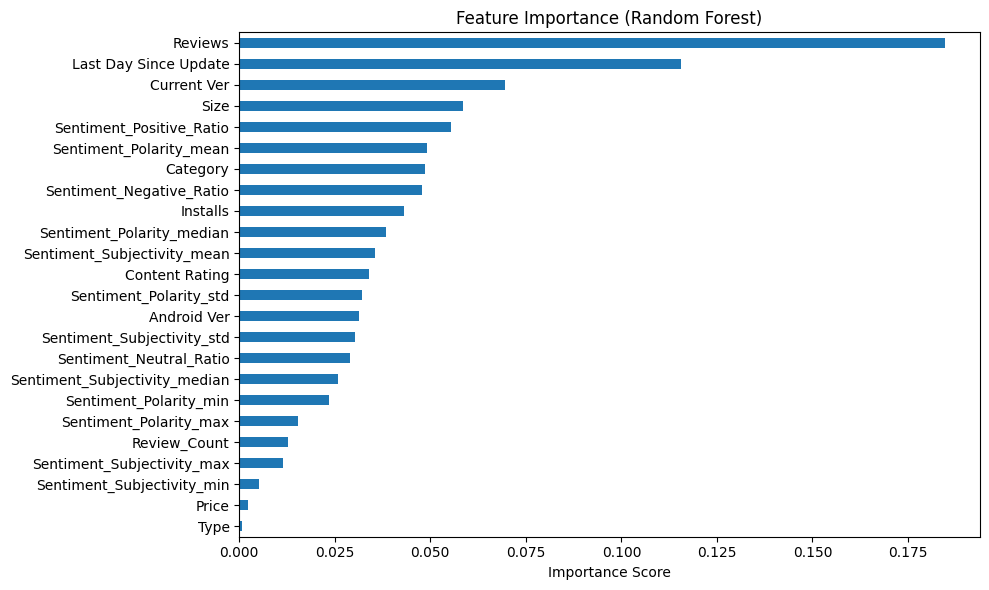

In [ ]:
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh', figsize=(10, 6), title="Feature Importance (Random Forest)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

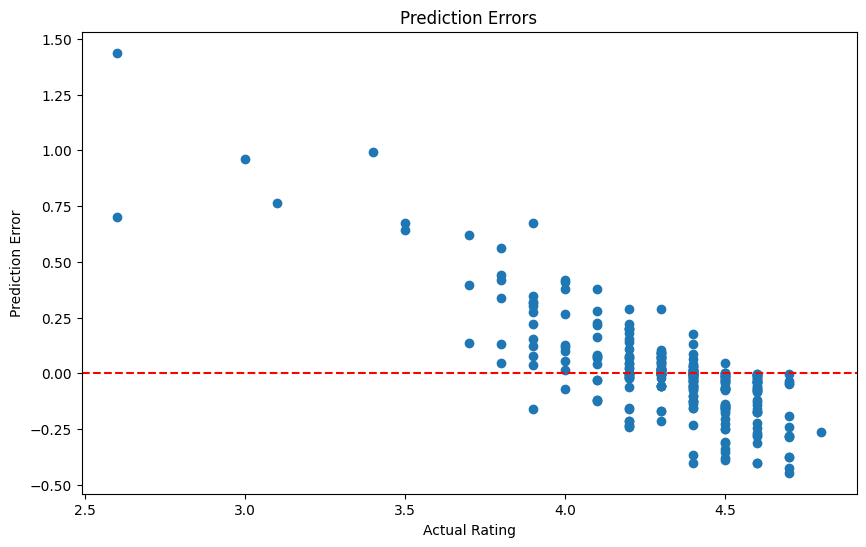

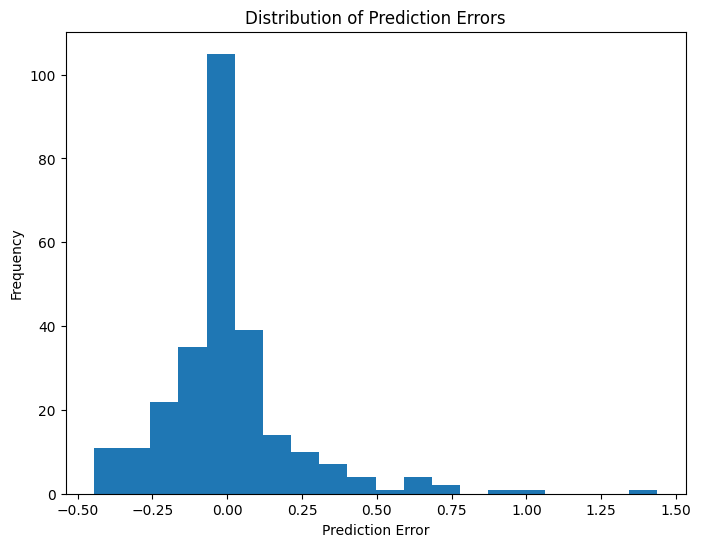

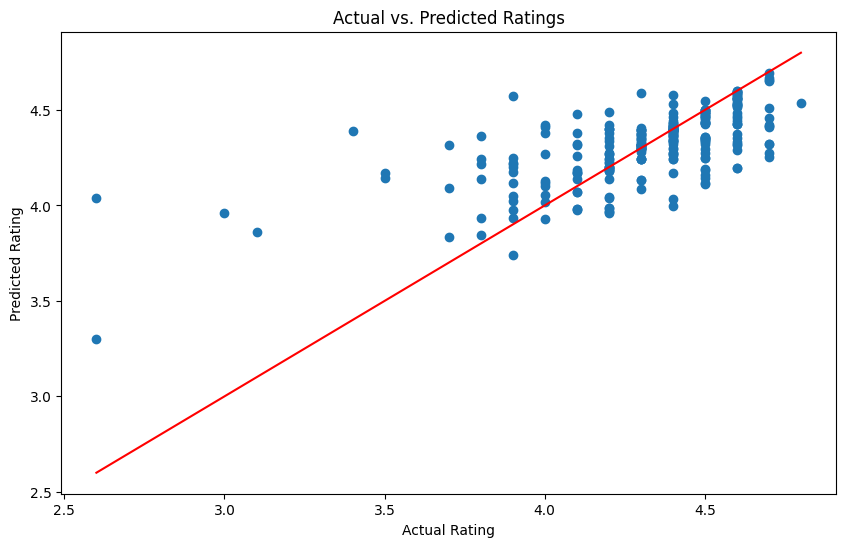

In [ ]:
# Calculating prediction errors
errors = y_pred - y_test.values.flatten()

# Creating a scatter plot of prediction errors
plt.figure(figsize=(10, 6))
plt.scatter(y_test.values.flatten(), errors)
plt.axhline(y=0, color='red', linestyle='--')  # Add a horizontal line at y=0
plt.xlabel("Actual Rating")
plt.ylabel("Prediction Error")
plt.title("Prediction Errors")
plt.show()

# Creating a histogram of prediction errors
plt.figure(figsize=(8, 6))
plt.hist(errors, bins=20)
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors")
plt.show()

# Creating a scatter plot of actual vs. predicted ratings
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.plot([min(y_test.values.flatten().min(), y_pred.min()), max(y_test.values.flatten().max(), y_pred.max())],
         [min(y_test.values.flatten().min(), y_pred.min()), max(y_test.values.flatten().max(), y_pred.max())], color='red')  # Add a diagonal line
plt.xlabel("Actual Rating")
plt.ylabel("Predicted Rating")
plt.title("Actual vs. Predicted Ratings")
plt.show()



###  Training Another ERROR-BASED Learning Algorithm, XGBoost

We implemented an XGBoost Regressor to predict app ratings using the same features as before.

**Model Performance:**
- Mean Squared Error (MSE): 0.0473
- R² Score: 0.4941

**Feature Importance Highlights:**
- Sentiment_Polarity_median
- Sentiment_Subjectivity_std
- Sentiment_Subjectivity_median
- Review_Count
- Sentiment_Positive_Ratio

**Visual Insights:**
- A bar chart showing the most important features based on gain
- Scatter plot of prediction errors to show spread
- Histogram of error distribution centered near zero
- Actual vs. Predicted scatter plot aligned along the diagonal

This model performed better than Random Forest and captured patterns more effectively.


In [ ]:
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=17
)

xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=17, ...)

In [ ]:
y_pred = xgb_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"XGBoost Mean Squared Error: {mse:.4f}")
print(f"XGBoost R² Score: {r2:.4f}")

XGBoost Mean Squared Error: 0.0473
XGBoost R² Score: 0.4941


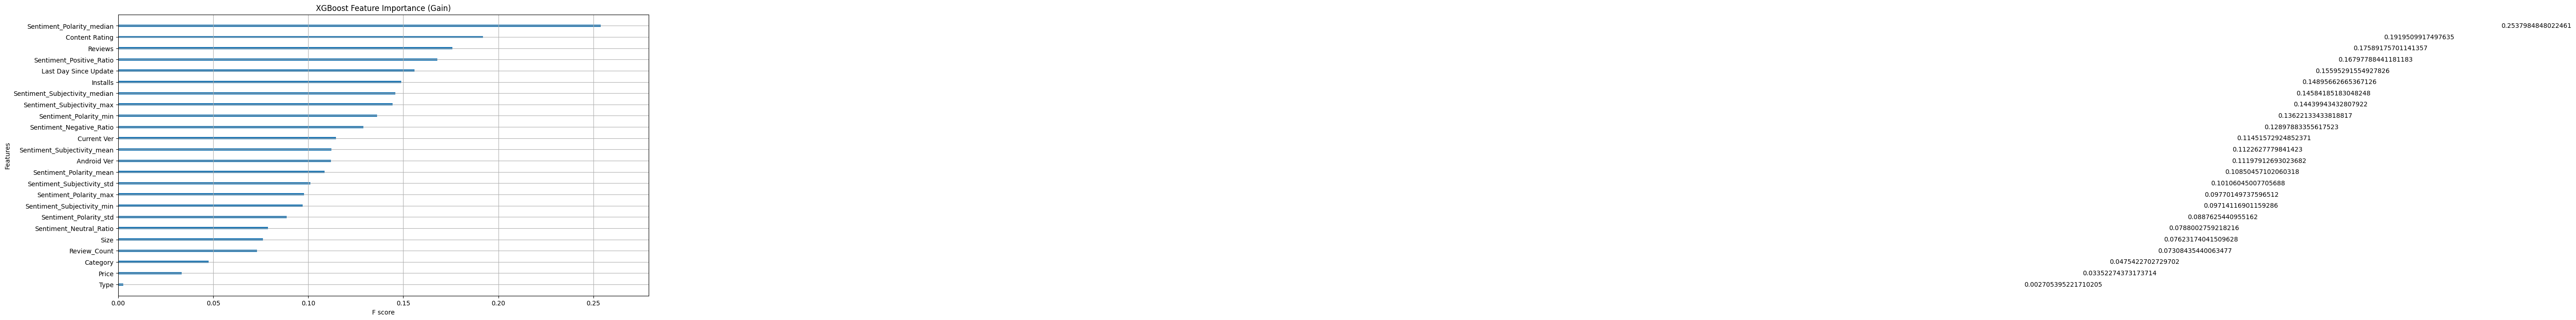

In [ ]:
xgb.plot_importance(xgb_model, importance_type='gain')
plt.title("XGBoost Feature Importance (Gain)")
plt.show()

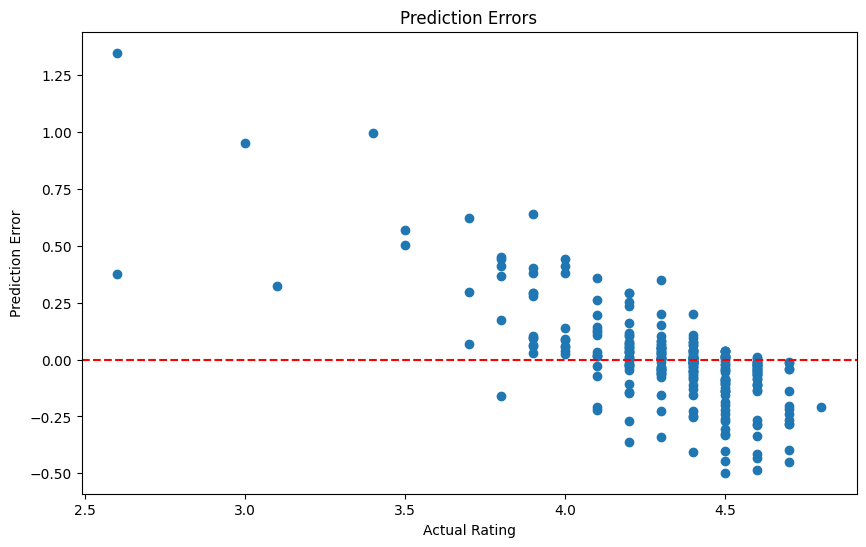

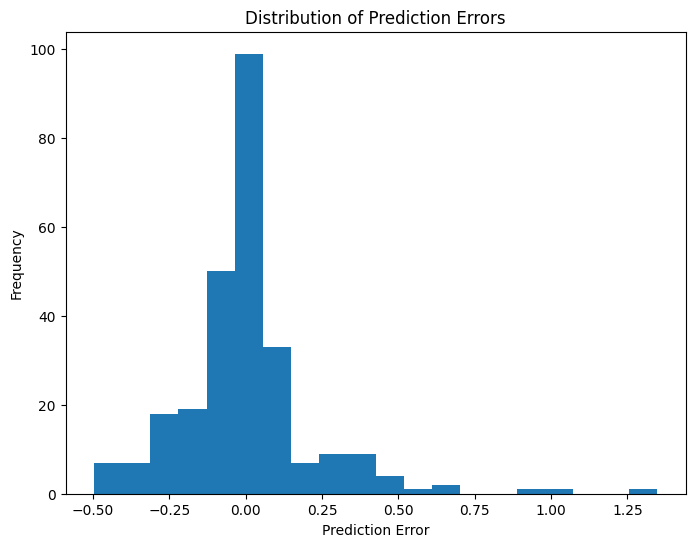

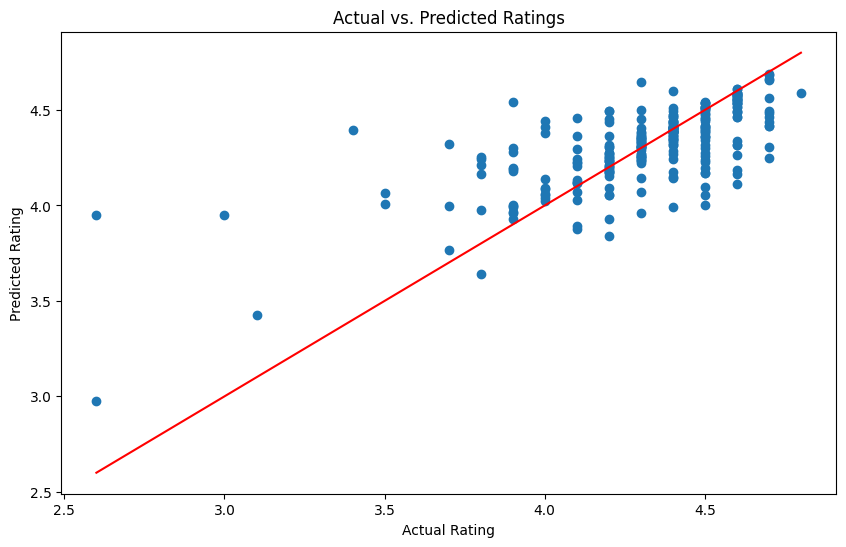

In [ ]:
# Calculating prediction errors
errors = y_pred - y_test.values.flatten()

# Creating a scatter plot of prediction errors
plt.figure(figsize=(10, 6))
plt.scatter(y_test.values.flatten(), errors)
plt.axhline(y=0, color='red', linestyle='--')  # Add a horizontal line at y=0
plt.xlabel("Actual Rating")
plt.ylabel("Prediction Error")
plt.title("Prediction Errors")
plt.show()

# Creating a histogram of prediction errors
plt.figure(figsize=(8, 6))
plt.hist(errors, bins=20)
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors")
plt.show()

# Creating a scatter plot of actual vs. predicted ratings
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.plot([min(y_test.values.flatten().min(), y_pred.min()), max(y_test.values.flatten().max(), y_pred.max())],
         [min(y_test.values.flatten().min(), y_pred.min()), max(y_test.values.flatten().max(), y_pred.max())], color='red')  # Add a diagonal line
plt.xlabel("Actual Rating")
plt.ylabel("Predicted Rating")
plt.title("Actual vs. Predicted Ratings")
plt.show()



### Training a SIMILARITY-BASED Learning Algorithm, K-Nearest Neighbors (KNN)
We implemented a K-Nearest Neighbors Regressor with `k=15` to predict app ratings by identifying similar data points based on proximity in feature space.

#### Model Performance:

- **Mean Squared Error (MSE):** 0.0795  
- **Mean Absolute Error (MAE):** 0.2046  
- **R² Score:** 0.1491

#### Visual Insights:

- A **scatter plot** of prediction errors with a red baseline at 0 shows error distribution across actual ratings.
- A **histogram** of prediction errors indicates the frequency of deviations.
- A **scatter plot** of actual vs. predicted values includes a red diagonal line to assess how close predictions were to the ground truth.

This section demonstrates the KNN model's performance. While it captures local patterns based on proximity, its lower R² score suggests it may not generalize as well as other models for this specific task.


In [ ]:
# Initializing the KNN regressor
knn = KNeighborsRegressor(n_neighbors=15)

# Training the KNN model
knn.fit(X_train, y_train)

# Making predictions on the test set
y_pred_knn = knn.predict(X_test)

# Evaluating the model
mse_knn = mean_squared_error(y_test, y_pred_knn)
mae_knn = mean_absolute_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)

print(f"KNN Mean Squared Error: {mse_knn:.4f}")
print(f"KNN Mean Absolute Error: {mae_knn:.4f}")
print(f"KNN R² Score: {r2_knn:.4f}")


KNN Mean Squared Error: 0.0795
KNN Mean Absolute Error: 0.2046
KNN R² Score: 0.1491


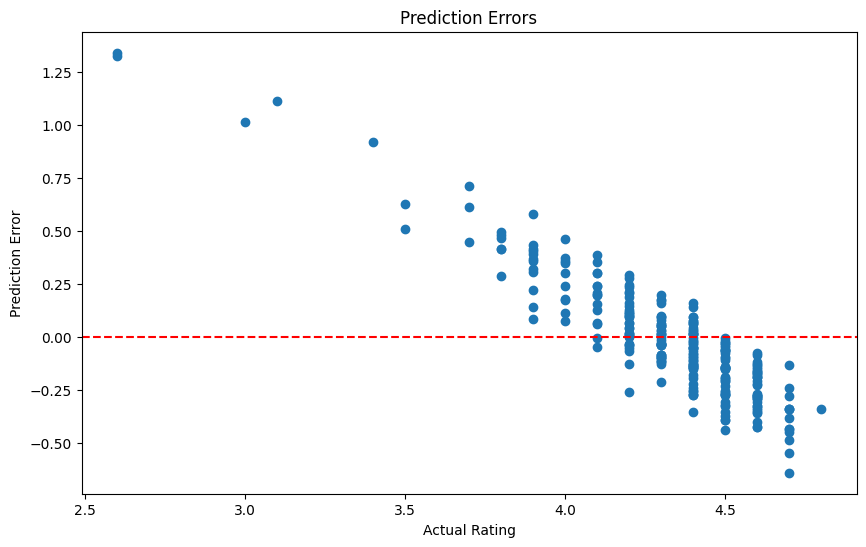

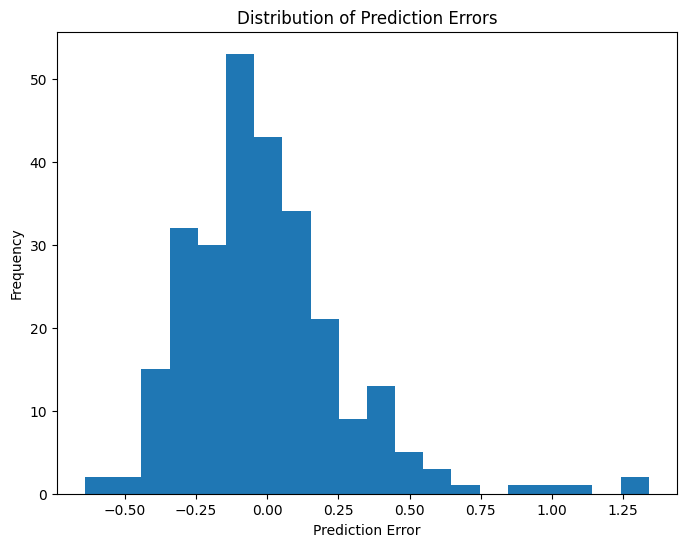

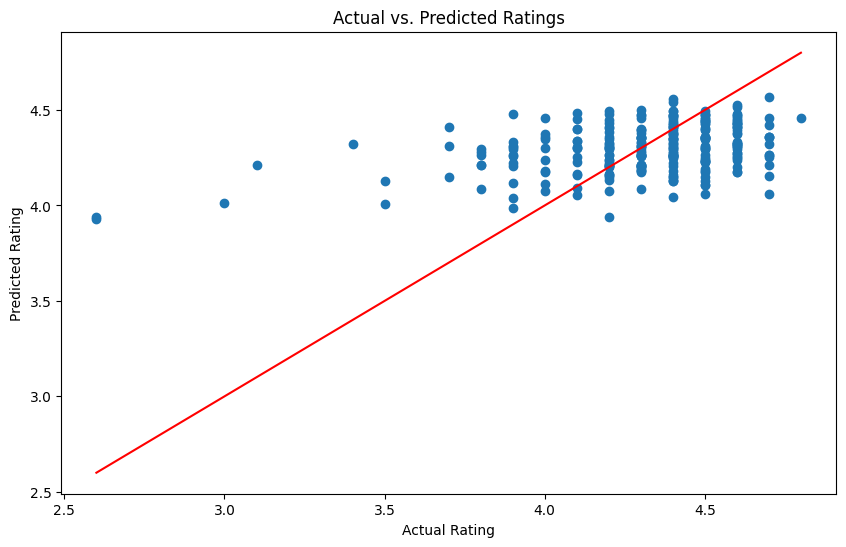

In [ ]:
# Calculating prediction errors
y_pred_knn = y_pred_knn.flatten()
errors = y_pred_knn - y_test.values.flatten()

# Creating a scatter plot of prediction errors
plt.figure(figsize=(10, 6))
plt.scatter(y_test.values.flatten(), errors)
plt.axhline(y=0, color='red', linestyle='--')  # Add a horizontal line at y=0
plt.xlabel("Actual Rating")
plt.ylabel("Prediction Error")
plt.title("Prediction Errors")
plt.show()

# Creating a histogram of prediction errors
plt.figure(figsize=(8, 6))
plt.hist(errors, bins=20)
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors")
plt.show()

# Creating a scatter plot of actual vs. predicted ratings
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_knn)
plt.plot([min(y_test.values.flatten().min(), y_pred_knn.min()), max(y_test.values.flatten().max(), y_pred_knn.max())],
         [min(y_test.values.flatten().min(), y_pred_knn.min()), max(y_test.values.flatten().max(), y_pred_knn.max())], color='red')  # Add a diagonal line
plt.xlabel("Actual Rating")
plt.ylabel("Predicted Rating")
plt.title("Actual vs. Predicted Ratings")
plt.show()



## 📘 Final Summary & Reflections



###  Analysis Approach
We began by merging two datasets—app metadata and user reviews—on the "App" column. After cleaning, transforming, and engineering features, we trained three regression models:

- **Random Forest Regressor** (Error-Based)
- **XGBoost Regressor** (Error-Based)
- **K-Nearest Neighbors Regressor** (Similarity-Based)

Each model was evaluated using:
- **Mean Squared Error (MSE)**
- **Mean Absolute Error (MAE)**
- **R² Score**

We also visualized prediction errors and feature importances to better understand how each feature contributed to the model’s predictions.

---

###  Performance Comparison

| Model            | MSE     | MAE     | R² Score |
|------------------|---------|---------|----------|
| Random Forest    | 0.0529  | 0.1433  | 0.4333   |
| XGBoost          | 0.0473  |   -     | 0.4941   |
| KNN              | 0.0795  | 0.2046  | 0.1491   |

- **XGBoost** delivered the best results, capturing complex patterns and achieving the highest accuracy.
- **Random Forest** performed well with stable results, confirming its strength as a reliable ensemble model.
- **KNN** had the weakest performance due to limitations in handling high-dimensional or noisy data.

---

###  Key Insights

- Features like **Review Count**, **Last Day Since Update**, **App Size**, **Current Version**, and **Sentiment Polarity** were consistently among the top predictors across all models.
- Models that used sentiment data performed better, showing that **user feedback (quality and emotion)** plays an important role in app ratings.
- Visualizations confirmed that predictions were generally close to actual values, especially for the stronger models.

---

## Conclusion

In this project, we explored what drives app ratings on the Google Play Store by combining app metadata with user sentiment data. Using both Error-Based (Random Forest, XGBoost) and Similarity-Based (KNN) models, we found that apps with more reviews, frequent updates, and higher positive sentiment tend to receive better ratings.

XGBoost performed the best, showing its strength in capturing non-linear patterns and handling complex datasets. KNN, while intuitive, didn’t perform as well on this task.

The key takeaway is simple: **listen to your users**. Reviews are not just numbers—they carry emotional value. Keeping apps updated and maintaining a positive user experience can directly influence how well an app is rated.
